## 【事前準備】

In [1]:
# scikit-learnの「set_config(display="diagram")」を使用するため、scikitlearnを最新verに更新
# !pip install scikit-learn==0.23.2 --target drive/My\ Drive/MyModule
# !pip install scikit-learn==0.23.2
# !pip install h5py==2.10
# !pip install keras==2.3.1
# !pip install keras-applications==1.0.7
# !pip install tensorflow==1.14
# !pip install -q -U albumentations   # データ拡張用ライブラリ
!pip list
## Google Drive上にインストールしたモジュールのインポート##
import sys
sys.path.append('/content/drive/My Drive/MyModule')

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.2
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.0.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheControl

In [2]:
## モジュールのインポート ##
# 一般
import os
import glob
import re
import xml.etree.ElementTree as ET
import random
import math
import collections
# データ分析
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style
%matplotlib inline
matplotlib.style.use('ggplot')
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
# 決定木可視化のためのツール
import graphviz
import pydotplus
# from IPython.display import Image
# from sklearn.externals.six import StringIO
# TensorFlow
import tensorflow as tf
# Keras
# from keras.datasets import mnist
# SciPy
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix, lil_matrix
# 画像データ編集
from PIL import Image
import cv2
import albumentations as A
# 自然言語処理
from gensim.models import Word2Vec
# その他
from google.colab import drive #GoogleDriveモジュール
# drive.mount('/content/drive') #GoogleDriveのマウント
# os.chdir('/content/drive/My Drive/DIVE INTO CODE/Sprint/Sprint17/ObjectDetection-master')

### ●推定器の評価指標を記録するスコアボードのクラス

In [3]:
## 推定器の指標値を記録するスコアボードのクラス ##
class ScoreBoard():
    def __init__(self, name1=None, name2=None):
        self.df_score = pd.DataFrame([])   # 各指標値を記録するDataFrame
        self.confusion_matrix_dic = {}   # 混同行列の辞書
        if (name1 is None):   name1 = ""
        if (name2 is None):   name2 = ""
        self.name1 = name1
        self.name2 = name2
        print("{}スコアボード{}が生成されました。".format(self.name1, self.name2))

    def calcurate_scores(self, arg_y_true, arg_y_predict, arg_y_predict_proba=None, arg_columns=None):

        if ((len(np.unique(arg_y_true)) <= 2) and (len(np.unique(arg_y_predict)) <= 2)):
            # 2値分類の評価指標
            accuracy = accuracy_score(arg_y_true, arg_y_predict)    # Accuracy（正解率）
            precision = precision_score(arg_y_true, arg_y_predict)    #Precision（適合率）
            recall = recall_score(arg_y_true, arg_y_predict)    #Recall（再現率）
            f1 = f1_score(arg_y_true, arg_y_predict)    #F値
        else:
            # 3値以上の分類の評価指標
            accuracy = accuracy_score(arg_y_true, arg_y_predict)    # Accuracy（正解率）
            precision = precision_score(arg_y_true, arg_y_predict, average="macro")    #Precision（適合率）
            recall = recall_score(arg_y_true, arg_y_predict, average="macro")    #Recall（再現率）
            f1 = f1_score(arg_y_true, arg_y_predict, average="macro")    #F値

        #AUC
        if (arg_y_predict_proba is not None):
            roc_auc = roc_auc_score(arg_y_true, arg_y_predict_proba)
            score_list = [accuracy, precision, recall, f1, roc_auc]
            index_list = ["Accuacy", "Precision", "Recall", "F1", "ROC_AUC"]
        else:
            score_list = [accuracy, precision, recall, f1]
            index_list = ["Accuacy", "Precision", "Recall", "F1"]

        #Confusion matrix（混同行列）
        print("\n")
        print("###Confusion matrix（混同行列）###")
        matrix = confusion_matrix(arg_y_true, arg_y_predict)
        df_confusion_matrix = pd.DataFrame(matrix)
        dic = {arg_columns:df_confusion_matrix}
        self.confusion_matrix_dic.update(dic)   # 評価名称をキーにして混同行列を辞書へ追加
        display(df_confusion_matrix)

        #指標値の比較用テーブルに登録
        # if(self.df_score.empty):
        #     self.df_score = pd.DataFrame([accuracy, precision, recall, f1, roc_auc], index=["Accuacy", "Precision", "Recall", "F1", "ROC_AUC"], columns=[arg_columns])
        # else:
        df_score_temp = pd.DataFrame(data=score_list, index=index_list, columns=[arg_columns])
        self.df_score = pd.concat([self.df_score, df_score_temp], axis=1)
        print("\n")
        print("{}スコアボード{}:".format(self.name1, self.name2))
        display(self.df_score)

        # #ROC曲線、AUC
        # #y_testの値を2→1, 1→0に変換
        # y_test1_dummy = np.where(y_test1==1, 0, 1)
        # fpr, tpr, thresholds = metrics.roc_curve(y_test1_dummy, y_predict_proba[:, -1]) # FPR（偽陽性率）、TPR（真陽性率）、閾値を算出
        # auc = metrics.auc(fpr, tpr)  # AUCを算出
        # plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
        # plt.legend()
        # plt.title('ROC curve')
        # plt.xlabel('False Positive Rate')
        # plt.ylabel('True Positive Rate')
        # plt.grid(True)

        # 決定領域を描画
        # decision_region(X_train_transformed, y_train, model=clf, step=0.01, title='decision region', xlabel=df3.columns[0], ylabel=df3.columns[1], target_names=df3.iloc[:, -1].unique())
        
        return
    def display(self, key=None):
        if (key is not None):
            print("###Confusion matrix（混同行列）###")
            display(self.confusion_matrix_dic[key])
        print("###スコアボード###")
        display(self.df_score)
        return

    def reset_score(self):
        self.df_score = pd.DataFrame([])  # スコアボードを初期化
        return


# スコアボードをインスタンス化
score_board1 = ScoreBoard(name2 = "1")
score_board2 = ScoreBoard(name2 = "2")
score_board3 = ScoreBoard(name2 = "3")

スコアボード1が生成されました。
スコアボード2が生成されました。
スコアボード3が生成されました。


### ●IMDB映画レビューデータセット

In [4]:
# IMDBをカレントフォルダにダウンロード
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# 解凍
!tar zxf aclImdb_v1.tar.gz
# aclImdb/train/unsupはラベル無しのため削除
!rm -rf aclImdb/train/unsup
# IMDBデータセットの説明を表示
!cat aclImdb/README

--2021-09-12 02:53:14--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  81.8MB/s    in 1.0s    

2021-09-12 02:53:15 (81.8 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an a

In [5]:
from sklearn.datasets import load_files
train_review = load_files('./aclImdb/train/', encoding='utf-8')
x_train, y_train = train_review.data, train_review.target
test_review = load_files('./aclImdb/test/', encoding='utf-8')
x_test, y_test = test_review.data, test_review.target
# ラベルの0,1と意味の対応の表示
print(train_review.target_names)

['neg', 'pos']


■このデータセットについて

中身を見てみると、英語の文章が入っていることが分かります。

In [6]:
print("x_train[0] : {}".format(x_train[0]))

x_train[0] : Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty.


In [7]:
print("x_train[0:3] : {}".format(x_train[0:3]))

x_train[0:3] : ["Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty.", 'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are

In [8]:
print(y_train)
print(np.unique(y_train))
print(len(x_train))
print(y_train.shape)
print(len(x_test))
print(y_test.shape)

[1 0 1 ... 0 0 0]
[0 1]
25000
(25000,)
25000
(25000,)


このサイトではユーザが映画に対して1から10点の評価とコメントを投稿することができます。そのデータベースから訓練データは25000件、テストデータは25000件のデータセットを作成しています。


4点以下を否定的、7点以下を肯定的なレビューとして2値のラベル付けしており、これにより感情の分類を行います。5,6点の中立的なレビューはデータセットに含んでいません。また、ラベルは訓練用・テスト用それぞれで均一に入っています。詳細はダウンロードしたREADMEを確認してください。

単純ながら効果的な方法として BoW (Bag of Words) があります。これは、サンプルごとに単語などの 登場回数 を数えたものをベクトルとする方法です。単語をカテゴリとして捉え one-hot表現 していることになります。

例として、IMDBデータセットからある3文の最初の5単語を抜き出したものを用意しました。

In [9]:
mini_dataset = \
  ["This movie is very good.",
  "This film is a good",
  "Very bad. Very, very bad."]

この3文にBoWを適用させてみます。scikit-learnのCountVectorizerを利用します。


sklearn.feature_extraction.text.CountVectorizer — scikit-learn 0.21.3 documentation

In [10]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')
# bow = (vectorizer.fit_transform(mini_dataset)).toarray()
mini_dataset_transformed = vectorizer.fit_transform(mini_dataset)
print("mini_dataset_transformed:")
print(mini_dataset_transformed)
bow = mini_dataset_transformed.toarray()
# DataFrameにまとめる
df = pd.DataFrame(bow, columns=vectorizer.get_feature_names())
display(df)

mini_dataset_transformed:
  (0, 6)	1
  (0, 5)	1
  (0, 4)	1
  (0, 7)	1
  (0, 3)	1
  (1, 6)	1
  (1, 4)	1
  (1, 3)	1
  (1, 2)	1
  (1, 0)	1
  (2, 7)	3
  (2, 1)	2


,a,bad,film,good,is,movie,this,very
0,0,0,0,1,1,1,1,1
1,1,0,1,1,1,0,1,0
2,0,2,0,0,0,0,0,3


例にあげた3文の中で登場する8種類の単語が列名になり、0,1,2番目のサンプルでそれらが何回登場しているかを示しています。2番目のサンプル「Very bad. Very, very bad.」ではbadが2回、veryが3回登場しています。列名になっている言葉はデータセットが持つ 語彙 と呼びます。


テキストはBoWにより各サンプルが語彙数の次元を持つ特徴量となり、機械学習モデルへ入力できるようになります。この時使用したテキスト全体のことを コーパス と呼びます。語彙はコーパスに含まれる言葉よって決まり、それを特徴量としてモデルの学習を行います。そのため、テストデータではじめて登場する語彙はベクトル化される際に無視されます。

## 前処理

CountVectorizerクラスでは大文字は小文字に揃えるという 前処理 が自動的に行われています。こういった前処理は自然言語処理において大切で、不要な記号などの消去（テキストクリーニング）や表記揺れの統一といったことを別途行うことが一般的です。


語形が「see」「saw」「seen」のように変化する単語に対して語幹に揃える ステミング と呼ばれる処理を行うこともあります。


## トークン

BoWは厳密には単語を数えているのではなく、 トークン（token） として定めた固まりを数えます。


何をトークンとするかはCountVectorizerでは引数token_patternで 正規表現 の記法により指定されます。デフォルトはr'(?u)\b\w\w+\b'ですが、上の例ではr'(?u)\b\w+\b'としています。


デフォルトでは空白・句読点・スラッシュなどに囲まれた2文字以上の文字を1つのトークンとして抜き出すようになっているため、「a」や「I」などがカウントされません。英語では1文字の単語は文章の特徴をあまり表さないため、除外されることもあります。しかし、上の例では1文字の単語もトークンとして抜き出すように引数を指定しています。



## 正規表現


正規表現は前処理の際にも活用しますが、ここでは詳細は扱いません。Pythonではreモジュールによって正規表現操作ができます。


re — 正規表現操作


正規表現を利用する際はリアルタイムで結果を確認できる以下のようなサービスが便利です。


Online regex tester and debugger: PHP, PCRE, Python, Golang and JavaScript

## 形態素解析

英語などの多くの言語では空白という分かりやすい基準でトークン化が行えますが、日本語ではそれが行えません。


日本語では名詞や助詞、動詞のように異なる 品詞 で分けられる単位で 分かち書き することになります。例えば「私はプログラミングを学びます」という日本語の文は「私/は/プログラミング/を/学び/ます」という風になります。


これには MeCab や Janome のような形態素解析ツールを用います。Pythonから利用することも可能です。MeCabをウェブ上で簡単に利用できるWeb茶まめというサービスも国立国語研究所が提供しています。


自然言語では新しい言葉も日々生まれますので、それにどれだけ対応できるかも大切です。MeCab用の毎週更新される辞書として mecab-ipadic-NEologd がオープンソースで存在しています。

mecab-ipadic-neologd/README.ja.md at master · neologd/mecab-ipadic-neologd

## n-gram

上のBoWの例では1つの単語（トークン）毎の登場回数を数えましたが、これでは語順はまったく考慮されていません。


考慮するために、隣あう単語同士をまとめて扱う n-gram という考え方を適用することがあります。2つの単語をまとめる場合は 2-gram (bigram) と呼び、次のようになります。

In [11]:
# ngram_rangeで利用するn-gramの範囲を指定する
vectorizer = CountVectorizer(ngram_range=(2, 2), token_pattern=r'(?u)\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,a good,bad very,film is,is a,is very,movie is,this film,this movie,very bad,very good,very very
0,0,0,0,0,1,1,0,1,0,1,0
1,1,0,1,1,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,2,0,1


2-gramにより「very good」と「very bad」が区別して数えられています。


単語をまとめない場合は 1-gram (unigram) と呼びます。3つまとめる3-gram(trigram)など任意の数を考えることができます。1-gramと2-gramを組み合わせてBoWを行うといったこともあります。

## 【問題1】BoWのスクラッチ実装
以下の3文のBoWを求められるプログラムをscikit-learnを使わずに作成してください。1-gramと2-gramで計算してください。

This movie is SOOOO funny!!!

What a movie! I never

best movie ever!!!!! this movie

In [12]:
mini_dataset = \
  ["This movie is SOOOO funny!!!",
   "What a movie! I never",
   "best movie ever!!!!! this movie"]

# mini_dataset = \
#   ["This movie is very good.",
#   "This film is a good",
#   "Very bad. Very, very bad."]

In [13]:
# bow作成用関数 定義
def create_bow(corpus, n_gram=1):
    df_bow = pd.DataFrame(data=[])

    p = re.compile(r'(?u)\b\w+\b')

    # corpusの各文字列を順番に処理
    for i, s in enumerate(corpus):
        # 各コーパスのサンプルに含まれるトークン（単語）のリストを作成
        token_list_temp = p.findall(s)
        token_list_temp = [token.lower() for token in token_list_temp]  # 大文字がある場合は小文字に統一
        # print(token_list_temp)

        # 2-gram以上の場合、複数のトークンを結合
        if (n_gram > 1):
            token_list = []
            for k in range(len(token_list_temp) - n_gram + 1):
                token_temp = ""
                for j in range(n_gram):
                    token_temp += (token_list_temp[k + j] + " ")
                token_list.append(token_temp)
        # 1-gramの場合、token_list_tempをそのまま使用
        else:
            token_list = token_list_temp
        # print(token_list)

        # 各トークンの出現回数の辞書を作成
        token_dict = collections.Counter(token_list)
        # print(token_dict)
        # print(type(token_dict))
        # BoWのデータフレームを作成
        columns = list(token_dict.keys())
        data = np.array(list(token_dict.values()))
        # print(columns, data)
        df_bow_temp = pd.DataFrame(data=data.reshape(1, -1), index=[i], columns=columns)
        df_bow = pd.concat([df_bow, df_bow_temp], axis=0)

    df_bow = df_bow.fillna(0)
    df_bow = df_bow.astype(np.uint64)
    # display(df_bow)

    return df_bow

In [14]:
df_bow = create_bow(corpus=mini_dataset, n_gram=1)
display(df_bow)

,this,movie,is,soooo,funny,what,a,i,never,best,ever
0,1,1,1,1,1,0,0,0,0,0,0
1,0,1,0,0,0,1,1,1,1,0,0
2,1,2,0,0,0,0,0,0,0,1,1


In [15]:
df_bow = create_bow(corpus=mini_dataset, n_gram=2)
display(df_bow)

,this movie,movie is,is soooo,soooo funny,what a,a movie,movie i,i never,best movie,movie ever,ever this
0,1,1,1,1,0,0,0,0,0,0,0
1,0,0,0,0,1,1,1,1,0,0,0
2,1,0,0,0,0,0,0,0,1,1,1


BoWの発展的手法として TF-IDF もよく使われます。これは Term Frequency (TF) と Inverse Document Frequency (IDF) という2つの指標の組み合わせです。


《標準的なTF-IDFの式》


Term Frequency:

$$
tf(t,d) = \frac{n_{t,d}}{\sum_{s \in d}n_{s,d}}
$$

n
t
,
d
 : サンプルd内のトークンtの出現回数（BoWと同じ）


∑
s
∈
d
n
s
,
d
 : サンプルdの全トークンの出現回数の和



Inverse Document Frequency:

$$
idf(t) = \log{\frac{N}{df(t)}}
$$

N
 : サンプル数


d
f
(
t
)
 : トークンtが出現するサンプル数


＊logの底は任意の値

TF-IDF:

$$
tfidf(t, d) = tf(t, d) \times idf(t)
$$


## IDF

IDFはそのトークンがデータセット内で珍しいほど値が大きくなる指標です。


サンプル数
N
 をIMDB映画レビューデータセットの訓練データに合わせ25000として、トークンが出現するサンプル数
d
f
(
t
)
 を変化させたグラフを確認してみると、次のようになります。



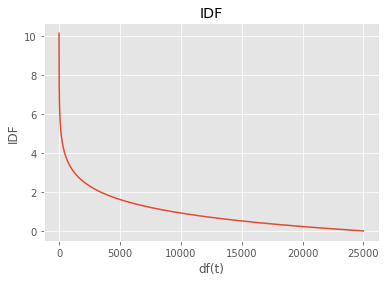

In [16]:
import numpy as np
import matplotlib.pyplot as plt
n_samples = 25000
idf = np.log(n_samples/np.arange(1,n_samples))
plt.title("IDF")
plt.xlabel("df(t)")
plt.ylabel("IDF")
plt.plot(idf)
plt.show()

TF-IDFではこの数を出現回数に掛け合わせるので、珍しいトークンの登場に重み付けを行なっていることになります。

## ストップワード

あまりにも頻繁に登場するトークンは、値を小さくするだけでなく、取り除くという前処理を加えることもあります。取り除くもののことを ストップワード と呼びます。既存のストップワード一覧を利用したり、しきい値によって求めたりします。


scikit-learnのCountVectorizerでは引数stop_wordsにリストで指定することで処理を行なってくれます。

In [17]:
vectorizer = CountVectorizer(stop_words=["is"], token_pattern=r'\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,a,best,ever,funny,i,movie,never,soooo,this,what
0,0,0,0,1,0,1,0,1,1,0
1,1,0,0,0,1,1,1,0,0,1
2,0,1,1,0,0,2,0,0,1,0


代表的な既存のストップワード一覧としては、NLTK という自然言語処理のライブラリのものがあげられます。あるデータセットにおいては特別重要な意味を持つ単語が一覧に含まれている可能性もあるため、使用する際は中身を確認することが望ましいです。

In [18]:
# はじめて使う場合はストップワードをダウンロード
import nltk
# stop_words = nltk.download('stopwords')
# print("stop word : {}".format(stop_words))
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print("stop word : {}".format(stop_words)) # 'i', 'me', 'my', ...

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
stop word : ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any',

逆に、登場回数が特に少ないトークンも取り除くことが多いです。すべてのトークンを用いるとベクトルの次元数が著しく大きくなってしまい計算コストが高まるためです。


scikit-learnのCountVectorizerでは引数max_featuresに最大の語彙数を指定することで処理を行なってくれます。以下の例では出現数が多い順に5個でベクトル化しています。

In [19]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', max_features = 5)
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,a,best,ever,movie,this
0,0,0,0,1,1
1,1,0,0,1,0
2,0,1,1,2,1


## 【問題2】TF-IDFの計算
IMDB映画レビューデータセットをTF-IDFによりベクトル化してください。NLTKのストップワードを利用し、最大の語彙数は5000程度に設定してください。テキストクリーニングやステミングなどの前処理はこの問題では要求しません。


TF-IDFの計算にはscikit-learnの以下のどちらかのクラスを使用してください。


sklearn.feature_extraction.text.TfidfVectorizer — scikit-learn 0.21.3 documentation

sklearn.feature_extraction.text.TfidfTransformer — scikit-learn 0.21.3 documentation


なお、scikit-learnでは標準的な式とは異なる式が採用されています。


また、デフォルトではnorm="l2"の引数が設定されており、各サンプルにL2正規化が行われます。norm=Noneとすることで正規化は行われなくなります。

Term Frequency:

$$
tf(t,d) = n_{t,d}
$$

n
t
,
d
 : サンプルd内のトークンtの出現回数


scikit-learnのTFは分母がなくなりBoWと同じ計算になります。

Inverse Document Frequency:

$$
idf(t) = \log{\frac{1+N}{1+df(t)}}+1
$$

N
 : サンプル数


d
f
(
t
)
 : トークンtが出現するサンプル数


＊logの底はネイピア数e


詳細は以下のドキュメントを確認してください。


5.2.3.4. Tf–idf term weighting — scikit-learn 0.21.3 documentation

In [20]:
vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=5000, token_pattern=r'(?u)\b\w+\b')

# TF-IDFの値の大きいトークンのみをベクトル化
X_train_transformed_temp = vectorizer.fit_transform(x_train)  # 学習データの各トークンのTD-IDF
X_train_transformed = X_train_transformed_temp.toarray()  # csr_matrix ⇒ ndarrayに変換
X_test_transformed_temp = vectorizer.transform(x_test)  # テストデータの各トークンのTD-IDF
X_test_transformed = X_test_transformed_temp.toarray()  # csr_matrix ⇒ ndarrayに変換

In [21]:
# print(X_train_transformed_temp)
print(X_train_transformed_temp.shape)
print(type(X_train_transformed_temp)) # fit_transformの戻り値は「scipy.sparse.csr.csr_matrix」型
print(X_train_transformed)
print(X_train_transformed.shape)
# print(X_test_transformed_temp)
print(X_test_transformed_temp.shape)
print(X_test_transformed)
print(X_test_transformed.shape)

feature_names = vectorizer.get_feature_names()
# print(feature_names)

# DataFrameにまとめる
df_train = pd.DataFrame(X_train_transformed, columns=feature_names)
display(df_train)
df_test = pd.DataFrame(X_test_transformed, columns=feature_names)
display(df_test)

(25000, 5000)
<class 'scipy.sparse.csr.csr_matrix'>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(25000, 5000)
(25000, 5000)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(25000, 5000)


,0,00,000,1,10,100,11,12,13,13th,14,15,16,17,18,1930,1930s,1933,1940,1950,1950s,1960,1960s,1968,1970,1970s,1971,1972,1973,1980,1980s,1983,1984,1987,1990,1993,1995,1996,1997,1999,...,worthwhile,worthy,would,wound,wounded,wow,wrap,wrapped,wreck,wrestling,write,writer,writers,writes,writing,written,wrong,wrote,wwii,x,ya,yard,yeah,year,years,yelling,yellow,yes,yesterday,yet,york,young,younger,youth,z,zero,zizek,zombie,zombies,zone
0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.054256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.164505,0.0,0.0,0.0,0.136932,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.103928,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.124442,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.085006,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.104143,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.0,0.0,0.0,0.000000,0.000000,0.052273,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.427149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.064930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.03913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036232,0.0,0.0,0.0,0.0,0.0,0.000000,0.095763,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
24996,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.093618,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.075540,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
24997,0.0,0.0,0.0,0.000000,0.068246,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
24998,0.0,0.0,0.0,0.101521,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000

,0,00,000,1,10,100,11,12,13,13th,14,15,16,17,18,1930,1930s,1933,1940,1950,1950s,1960,1960s,1968,1970,1970s,1971,1972,1973,1980,1980s,1983,1984,1987,1990,1993,1995,1996,1997,1999,...,worthwhile,worthy,would,wound,wounded,wow,wrap,wrapped,wreck,wrestling,write,writer,writers,writes,writing,written,wrong,wrote,wwii,x,ya,yard,yeah,year,years,yelling,yellow,yes,yesterday,yet,york,young,younger,youth,z,zero,zizek,zombie,zombies,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.066354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.065750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.075591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.101782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.039775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 【問題3】TF-IDFを用いた学習
問題2で求めたベクトルを用いてIMDB映画レビューデータセットの学習・推定を行なってください。モデルは2値分類が行える任意のものを利用してください。


ここでは精度の高さは求めませんが、最大の語彙数やストップワード、n-gramの数を変化させて影響を検証してみてください。

### ●データセット準備

In [22]:
# trainとvalに分割
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train_transformed, y_train, train_size=0.8, random_state=0)
X_test1 = X_test_transformed
y_test1 = y_test

### ●plot_training_curve関数

In [23]:
def plot_training_curve(history, metrics_list=["accuracy"]):
    for metrics in metrics_list:
        score = history.history[metrics]
        val_score = history.history['val_' + str(metrics)]

        # plt.figure(figsize=(8, 8))
        plt.figure()
        # plt.subplot(1, 2, 1)
        plt.plot(score, label=('Training ' + str(metrics)))
        plt.plot(val_score, label=('Validation ' + str(metrics)))
        plt.legend(loc='lower right')
        plt.title(('Training and Validation ' + str(metrics)))

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure()
    # plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

### ●学習・推定・評価

X.shape:
(20000, 5000)
y.shape:
(20000,)
Xv.shape:
(5000, 5000)
yv.shape:
(5000,)
Xt.shape:
(25000, 5000)
yt.shape:
(25000,)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              5001000   
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 501       
Total params: 5,502,001
Trainable params: 5,502,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
625/625 [==============================] - 4s 3ms/step - loss: 0.3287 - accuracy: 0.8477 - val_loss: 0.2823 - val_accuracy: 0.8620

Epoch 00001: val_loss improved from inf to 0.28228, saving model to model_weight.hdf5
Epoch 2/50
625/625 [

,0,1
0,11028,1472
1,2041,10459




スコアボード1:


,TF-IDF
Accuacy,0.859480
Precision,0.876624
Recall,0.836720
F1,0.856207


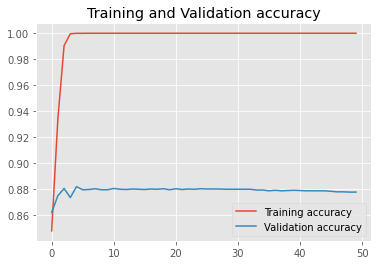

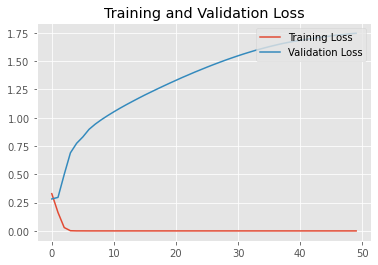

CPU times: user 2min 10s, sys: 17 s, total: 2min 27s
Wall time: 1min 44s


In [24]:
%%time
X = X_train1
y = y_train1
Xv = X_val1
yv = y_val1
Xt = X_test1
yt = y_test1

print("X.shape:")
print(X.shape)
print("y.shape:")
print(y.shape)
print("Xv.shape:")
print(Xv.shape)
print("yv.shape:")
print(yv.shape)
print("Xt.shape:")
print(Xt.shape)
print("yt.shape:")
print(yt.shape)
print("\n")


# ハイパーパラメータの設定
learning_rate = 0.001
batch_size = 10
num_epochs = 50
n_input = X.shape[1]
n_hidden1 = 1000
n_hidden2 = 500
n_samples = X.shape[0]
n_classes = 1

# モデルのインスタンス化
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_input,)),
    tf.keras.layers.Dense(n_hidden1, activation='relu'),
    tf.keras.layers.Dense(n_hidden2, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(n_classes)
    # tf.keras.layers.Dense(n_classes, activation='sigmoid')
])

# 各クラスに属する確率の推定用にモデルを拡張（ロジットをSigmoid関数 or Softmax関数に通す）
probability_model = tf.keras.Sequential([
          model,
          tf.keras.layers.Activation("sigmoid")
          # tf.keras.layers.Softmax()
])

# 最適化手法
optimizer=tf.keras.optimizers.Adam(learning_rate)    # Adam

# 損失関数
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)  # バイナリ交差エントロピー（2値分類）

# メトリクス
metrics=["accuracy"]

# モデルのコンパイル
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics
              )

# モデルのサマリー
model.summary()

# コールバック
callbacks = [
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),  # 早期終了
    tf.keras.callbacks.ModelCheckpoint('model_weight.hdf5', monitor='val_loss',verbose=1, save_best_only=True)  # 学習したパラメータを保存
]

# 学習
history = model.fit(X, y, validation_data=(Xv, yv), epochs=num_epochs, callbacks=callbacks)

# 推定
y_pred_proba = probability_model.predict(Xt)[:, 0]    # モデルの最終出力がロジットの場合
# y_pred_proba = model.predict(Xt)[:, 0]    # モデルの最終出力がSigmoid or Softmaxの場合

# 確率を0, 1に変換
y_pred = np.where(y_pred_proba >0.5, 1, 0)
print("y_pred_proba:")
print(y_pred_proba)
print("y_pred:")
print(y_pred)
print("y_true:")
# print(np.argmax(yt, axis=1))
print(yt)
print("\n")

# 評価
score = model.evaluate(Xt, yt, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

# 推定器のスコアを計算し、スコアボードに記録
score_board1.calcurate_scores(yt, y_pred, arg_columns="TF-IDF")

# 学習曲線
plot_training_curve(history=history, metrics_list=metrics)

### 【問題3 解答】
val_lossは最初から増加する一方だが、val_acc（検証データの正解率）は0.88まで出ており、BoWでもある程度は高い精度で推定できていると言える。

## 【問題4】TF-IDFのスクラッチ実装
以下の3文のTF-IDFを求められるプログラムをscikit-learnを使わずに作成してください。標準的な式と、scikit-learnの採用している式の2種類を作成してください。正規化は不要です。

This movie is SOOOO funny!!!

What a movie! I never

best movie ever!!!!! this movie

In [25]:
mini_dataset = \
  ["This movie is SOOOO funny!!!",
   "What a movie! I never",
   "best movie ever!!!!! this movie"]

### ●TF-IDF算出処理のスクラッチ実装（標準的な式）

$$
tf(t,d) = \frac{n_{t,d}}{\sum_{s \in d}n_{s,d}}
$$

$$
idf(t) = \log{\frac{N}{df(t)}}
$$

$$
tfidf(t, d) = tf(t, d) \times idf(t)
$$

In [26]:
# TF-IDF作成用関数（標準的な式） 定義
def create_tfidf_normal(corpus, n_gram=1):
    n_sample = len(corpus) # サンプル数
 
    # BoWを作成
    df_bow = create_bow(corpus=corpus, n_gram=n_gram)
    bow = np.array(df_bow)    # BoWのndarray
    columns = list(df_bow.columns)    # BoWの列名のリスト

    # 各トークンのTF: tf(t,d) = n_{t,d} / Σn_{s,d}    # TF:各サンプル内で高頻度で出現するトークン ⇒ 数値大
    tf = bow / bow.sum(axis=1).reshape(-1, 1)
    # 各トークンの出現するサンプル数
    df = np.count_nonzero((bow != 0), axis=0)
    # 各トークンのIDF: idf(t) = log(N / df(t))    # IDF:全サンプルを通して低頻度で出現するトークン ⇒ 数値大
    idf = np.log(n_sample / df)
    # 各トークンのTF-IDF: tf(t,d) * idf(t)    # TF-IDF:全サンプルを通して低頻度で出現し、且つ特定のサンプル内では高頻度で出現 ⇒ 数値大
    tfidf = tf * idf

    # print(bow)
    # print(bow.sum(axis=1).reshape(-1, 1))
    # print(tf)
    # print(n_sample)
    # print(df)
    # print(idf)
    # print(tfidf)
    
    df_tfidf = pd.DataFrame(data=tfidf, columns=columns)
    df_tfidf = df_tfidf.sort_index(axis=1, ascending=True)
    return df_tfidf

In [27]:
df_tfidf1 = create_tfidf_normal(corpus=mini_dataset, n_gram=1)
display(df_tfidf1)

,a,best,ever,funny,i,is,movie,never,soooo,this,what
0,0.000000,0.000000,0.000000,0.219722,0.000000,0.219722,0.0,0.000000,0.219722,0.081093,0.000000
1,0.219722,0.000000,0.000000,0.000000,0.219722,0.000000,0.0,0.219722,0.000000,0.000000,0.219722
2,0.000000,0.219722,0.219722,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.081093,0.000000


### ●TF-IDF算出処理のスクラッチ実装（scikit-learnの式）

$$
tf(t,d) = n_{t,d}
$$

$$
idf(t) = \log{\frac{1+N}{1+df(t)}}+1
$$

In [28]:
# TF-IDF作成用関数（scikit-learnの式） 定義
def create_tfidf_sklearn(corpus, n_gram=1):
    n_sample = len(corpus) # サンプル数
 
    # BoWを作成
    df_bow = create_bow(corpus=corpus, n_gram=n_gram)
    bow = np.array(df_bow)    # BoWのndarray
    columns = list(df_bow.columns)    # BoWの列名のリスト

    # 各トークンのTF: tf(t,d) = n_{t,d}    # TF:各サンプル内で高頻度で出現するトークン ⇒ 数値大
    tf = bow
    # 各トークンの出現するサンプル数
    df = np.count_nonzero((bow != 0), axis=0)
    # 各トークンのIDF: idf(t) = log((1 + N)/(1 + df(t)))+1    # IDF:全サンプルを通して低頻度で出現するトークン ⇒ 数値大
    idf = np.log((1 + n_sample) / (1 + df)) + 1
    # 各トークンのTF-IDF: tf(t,d) * idf(t)    # TF-IDF:全サンプルを通して低頻度で出現し、且つ特定のサンプル内では高頻度で出現 ⇒ 数値大
    tfidf = tf * idf

    # print(bow)
    # print(bow.sum(axis=1).reshape(-1, 1))
    # print(tf)
    # print(n_sample)
    # print(df)
    # print(idf)
    # print(tfidf)
    
    df_tfidf = pd.DataFrame(data=tfidf, columns=columns)
    df_tfidf = df_tfidf.sort_index(axis=1, ascending=True)
    return df_tfidf

In [29]:
df_tfidf2 = create_tfidf_sklearn(corpus=mini_dataset, n_gram=1)
display(df_tfidf2)

,a,best,ever,funny,i,is,movie,never,soooo,this,what
0,0.000000,0.000000,0.000000,1.693147,0.000000,1.693147,1.0,0.000000,1.693147,1.287682,0.000000
1,1.693147,0.000000,0.000000,0.000000,1.693147,0.000000,1.0,1.693147,0.000000,0.000000,1.693147
2,0.000000,1.693147,1.693147,0.000000,0.000000,0.000000,2.0,0.000000,0.000000,1.287682,0.000000


### ●【確認】scikit-learnによるTF-IDF


In [30]:
# vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=5000, token_pattern=r'(?u)\b\w+\b')
vectorizer = TfidfVectorizer(token_pattern=r'(?u)\b\w+\b', norm=None)   # 正規化:無し

# TF-IDFの値の大きいトークンのみをベクトル化
tdidf_csr = vectorizer.fit_transform(mini_dataset)  # 学習データの各トークンのTD-IDF
tdidf_ndarray = tdidf_csr.toarray()  # csr_matrix ⇒ ndarrayに変換

# print(tdidf_ndarray)
# print(tdidf_ndarray.shape)

feature_names = vectorizer.get_feature_names()
# print(feature_names)

# DataFrameにまとめる
df_tfidf = pd.DataFrame(tdidf_ndarray, columns=feature_names)
df_tfidf = df_tfidf.sort_index(axis=1, ascending=True)
display(df_tfidf)

,a,best,ever,funny,i,is,movie,never,soooo,this,what
0,0.000000,0.000000,0.000000,1.693147,0.000000,1.693147,1.0,0.000000,1.693147,1.287682,0.000000
1,1.693147,0.000000,0.000000,0.000000,1.693147,0.000000,1.0,1.693147,0.000000,0.000000,1.693147
2,0.000000,1.693147,1.693147,0.000000,0.000000,0.000000,2.0,0.000000,0.000000,1.287682,0.000000


### 【問題4 解答】
TF-IDF算出処理をスクラッチ実装したところ、scikit-learn方式のTF-IDFについては実際にscikit-learnと同じ出力が得られることを確認できた。

----------------------------------------------------------------------------------------------------------------------------
ニューラルネットワークを用いてベクトル化を行う手法が Word2Vec です。


BoWやTF-IDFはone-hot表現であったため、得られるベクトルの次元は語彙数分になります。そのため、語彙数を増やしにくいという問題があります。一方で、Word2Vecでは単語を任意の次元のベクトルに変換します。これをを Word Embedding（単語埋め込み） や 分散表現 と呼びます。変換操作を「ベクトル空間に埋め込む」と言うことが多いです。


Word2VecにはCBoWとSkip-gramという2種類の仕組みがあるため順番に見ていきます。

## CBoW
CBoW (Continuous Bag-of-Words) によるWord2Vecではある単語とある単語の間に来る単語を推定できるように全結合層2層のニューラルネットワークを学習します。


単語はコーパスの語彙数次元のone-hot表現を行なっておきます。そのため、入力と出力の次元は語彙数と同じになります。一方で、中間のノード数をWord2Vecにより得たい任意の次元数とします。これにより全結合層の重みは「得たい次元のノード数×語彙数」になります。このネットワークにより学習を行なった後、出力側の重みを取り出すことで、各語彙を表すベクトルを手に入れることができます。


間の単語の推定を行なっているため、同じ箇所で代替可能な言葉は似たベクトルになるというメリットもあります。これはBoWやTF-IDFでは得られない情報です。


あるテキストは「そのテキストの長さ（単語数）×Word2Vecで得た分散表現の次元数」の配列になりますが、各入力の配列を揃える必要があるモデルに入力するためには、短いテキストは空白を表す単語を加える パディング を行なったり、長いテキストは単語を消したりします。テキストを 固定長 にすると呼びます。

## ウィンドウサイズ
入力する単語は推定する前後1つずつだけでなく、複数個とする場合もあります。前後いくつを見るかの大きさを ウィンドウサイズ と呼びます。

## Skip-gram
CBoWとは逆にある単語の前後の単語を推定できるように全結合層2層のニューラルネットワークを学習する方法が Skip-gram です。学習を行なった後は入力側の重みを取り出し各語彙を表すベクトルとします。現在一般的に使われているのはCBoWよりもSki-gramです。

## 利用方法
Pythonでは Gensim ライブラリを用いて扱うことができます。


gensim: models.word2vec – Word2vec embeddings


BoWの例と同じ文章で学習してみます。CountVectorizerと異なり前処理を自動的に行なってはくれないため、単語（トークン）はリストで分割しておきます。また、大文字は小文字に揃え、記号は取り除きます。


デフォルトのパラメータではCBoWで計算されます。また、ウィンドウサイズはwindow=5に設定されています。

In [31]:
from gensim.models import Word2Vec
sentences = [['this', 'movie', 'is', 'very', 'good'], ['this', 'film', 'is', 'a', 'good'], ['very', 'bad', 'very', 'very', 'bad']]
model = Word2Vec(min_count=1, size=10) # 次元数を10に設定
model.build_vocab(sentences) # 準備
model.train(sentences, total_examples=model.corpus_count, epochs=model.iter) # 学習

print("語彙の一覧 : {}".format(model.wv.vocab.keys()))
for vocab in model.wv.vocab.keys():
  print("{}のベクトル : \n{}".format(vocab, model.wv[vocab]))

語彙の一覧 : dict_keys(['this', 'movie', 'is', 'very', 'good', 'film', 'a', 'bad'])
thisのベクトル : 
[-0.01684079  0.02630366  0.03829208  0.00717638 -0.04807004 -0.00109221
 -0.03171674 -0.0223158   0.03038767 -0.01256178]
movieのベクトル : 
[ 0.02497435 -0.03277809  0.03746207 -0.0202223   0.04624649 -0.0418618
 -0.04312602  0.0354108   0.00958103  0.00148391]
isのベクトル : 
[-0.03435303 -0.01834231  0.03418102 -0.01577247 -0.00260604  0.0176494
  0.04441253  0.02205763 -0.0253842   0.01624522]
veryのベクトル : 
[ 0.03603774  0.04065641 -0.02107254  0.04620998 -0.01919455 -0.01556324
  0.01303377  0.04111819  0.04879056 -0.00298646]
goodのベクトル : 
[-0.01251586  0.00707416  0.00190835 -0.04426724  0.03798026 -0.03467551
  0.02249912  0.02607647  0.03046543 -0.00432282]
filmのベクトル : 
[ 0.01484526  0.00958394 -0.04796204  0.00845011 -0.00103429  0.03800086
  0.04107806 -0.02349112  0.0155991  -0.02114002]
aのベクトル : 
[-0.03657558 -0.02021794 -0.03540432  0.01830741 -0.03986641 -0.01519449
 -0.00232182 -0.00931762 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """


このようにしてベクトルが得られます。

## 単語の距離

ベクトル間で計算を行うことで、ある単語に似たベクトルを持つ単語を見つけることができます。例えばgoodに似たベクトルの単語を3つ探します。

In [32]:
model.wv.most_similar(positive="good", topn=3)

[('bad', 0.6303034424781799),
 ('movie', 0.45061829686164856),
 ('is', 0.15977409482002258)]

今の例では3文しか学習していませんので効果を発揮しませんが、大きなコーパスで学習することで、並列関係のものが近くに来たりなど面白い結果が得られます。

## 可視化

2次元に圧縮することで単語ごとの位置関係を可視化することができます。以下はt-SNEを用いた例です。

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


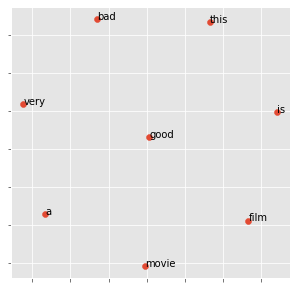

In [33]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
vocabs = model.wv.vocab.keys()
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model[vocabs])
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

IMDB映画レビューデータセットの訓練データをコーパスとしてWord2Vecを学習させ分散表現を獲得しましょう。

## 【問題5】コーパスの前処理
コーパスの前処理として、特殊文字（!など）やURLの除去、大文字の小文字化といったことを行なってください。また、単語（トークン）はリストで分割してください。


### ●preprocess_corpus関数

In [34]:
# 前処理用関数 定義
def preprocess_corpus(corpus, stop_words=None):
    df_bow = pd.DataFrame(data=[])

    p = re.compile(r'(?u)\b\w+\b')
    token_list = []

    # corpusの各文字列を順番に処理
    for i, s in enumerate(corpus):
        # 各コーパスのサンプルに含まれるトークン（単語）のリストを作成
        token_list_temp = p.findall(s)
        token_list_temp = [token.lower() for token in token_list_temp]  # 大文字がある場合は小文字に統一
        #ストップワードが指定されている場合はトークンリストからストップワードを除外する
        if (stop_words is not None):
            token_list_temp = [token.lower() for token in token_list_temp if token not in stop_words]
        # print(token_list_temp)
        token_list.append(token_list_temp)

    return token_list

In [35]:
# ミニデータセットで動作確認
mini_dataset = \
  ["This movie is SOOOO funny!!!",
   "What a movie! I never",
   "best movie ever!!!!! this movie"]

# 前処理実行（ストップワード無し）
token_list = preprocess_corpus(mini_dataset)
print(token_list)

# 前処理実行（ストップワード有り）
token_list = preprocess_corpus(mini_dataset, stop_words)
print(token_list)

[['this', 'movie', 'is', 'soooo', 'funny'], ['what', 'a', 'movie', 'i', 'never'], ['best', 'movie', 'ever', 'this', 'movie']]
[['movie', 'soooo', 'funny'], ['movie', 'never'], ['best', 'movie', 'ever', 'movie']]


### ●IMDB映画レビューデータセットの前処理

In [36]:
x_train_prepro = preprocess_corpus(x_train, stop_words)
x_test_prepro = preprocess_corpus(x_test, stop_words)
print("x_train_prepro[0:3] : {}".format(x_train_prepro[0:3]))

x_train_prepro[0:3] : [['zero', 'day', 'leads', 'think', 'even', 'think', 'two', 'boys', 'young', 'men', 'would', 'commit', 'mutual', 'suicide', 'via', 'slaughtering', 'classmates', 'captures', 'must', 'beyond', 'bizarre', 'mode', 'two', 'humans', 'decided', 'withdraw', 'common', 'civility', 'order', 'define', 'mutual', 'world', 'via', 'coupled', 'destruction', 'br', 'br', 'perfect', 'movie', 'given', 'money', 'time', 'filmmaker', 'actors', 'remarkable', 'product', 'terms', 'explaining', 'motives', 'actions', 'two', 'young', 'suicide', 'murderers', 'better', 'elephant', 'terms', 'film', 'gets', 'rationalistic', 'skin', 'far', 'far', 'better', 'film', 'almost', 'anything', 'likely', 'see', 'br', 'br', 'flawed', 'honest', 'terrible', 'honesty'], ['words', 'describe', 'bad', 'movie', 'explain', 'writing', 'see', 'get', 'grip', 'horrible', 'movie', 'really', 'recommend', 'many', 'clichés', 'mistakes', 'negative', 'things', 'imagine', 'make', 'cry', 'start', 'technical', 'first', 'lot', 'mi

## 【問題6】Word2Vecの学習
Word2Vecの学習を行なってください。

In [37]:
%%time
# Word2Vec生成用のモデル
model = Word2Vec(window=5, min_count=1, size=100) # ベクトルの次元数を100に設定
model.build_vocab(x_train_prepro) # 準備
print(model.corpus_count)
print(model.iter)

model.train(x_train_prepro, total_examples=model.corpus_count, epochs=model.iter) # 学習

25000
5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  import sys


CPU times: user 53.9 s, sys: 156 ms, total: 54 s
Wall time: 28.2 s


In [38]:
i = 0
for vocab in model.wv.vocab.keys():
    print("{}のベクトル : \n{}".format(vocab, model.wv[vocab]))
    i += 1
    if(i > 10):
        break

zeroのベクトル : 
[-0.06124164  0.07046339  0.64265245  0.18485215  0.67270494  1.0484968
 -0.2697275   0.14869635  0.3004749   0.46126395 -0.6272787  -0.5735969
 -0.39746276  0.15869536 -0.6243836   0.10927037 -0.37383506  1.0247829
 -0.90488446 -0.34507647 -0.98997366  1.1100886  -0.44203526 -0.29774758
  0.78476727  0.1596561  -0.17691872  0.3975331  -0.71570534 -0.786053
  0.6000937   0.27849072  0.31571448 -0.78299546 -0.4078327   1.223561
 -0.44562823  0.46893498 -1.1044093   0.09073798 -0.68336886 -0.01476599
 -0.81950104 -0.61059135  0.42890427 -0.3298992  -0.6854601   1.6288294
 -0.28994757  0.78014284 -0.5101424   0.01462968 -0.20544367 -0.17238706
 -0.22319564  0.58019584 -1.2887838  -0.8866527   0.59038836  0.6231526
  0.7217322  -0.472532   -0.50389904  0.40886107  1.2501996  -0.6880558
  0.7625052  -1.149326    0.02349949  0.5365031  -0.18400165  0.20820375
 -0.70897377 -0.13818368  0.08285338 -0.10242108 -0.74421674  0.6779206
  0.17942053  0.73351604  0.11022387 -0.73546934 

In [39]:
print("語彙の一覧 : {}".format(model.wv.vocab.keys()))
print("語彙の数 : {}".format(len(model.wv.vocab.keys())))

print(type(model.wv))
print(type(model.wv["zero"]))

語彙の一覧 : dict_keys(['zero', 'day', 'leads', 'think', 'even', 'two', 'boys', 'young', 'men', 'would', 'commit', 'mutual', 'suicide', 'via', 'slaughtering', 'classmates', 'captures', 'must', 'beyond', 'bizarre', 'mode', 'humans', 'decided', 'withdraw', 'common', 'civility', 'order', 'define', 'world', 'coupled', 'destruction', 'br', 'perfect', 'movie', 'given', 'money', 'time', 'filmmaker', 'actors', 'remarkable', 'product', 'terms', 'explaining', 'motives', 'actions', 'murderers', 'better', 'elephant', 'film', 'gets', 'rationalistic', 'skin', 'far', 'almost', 'anything', 'likely', 'see', 'flawed', 'honest', 'terrible', 'honesty', 'words', 'describe', 'bad', 'explain', 'writing', 'get', 'grip', 'horrible', 'really', 'recommend', 'many', 'clichés', 'mistakes', 'negative', 'things', 'imagine', 'make', 'cry', 'start', 'technical', 'first', 'lot', 'regarding', 'airplane', 'list', 'mention', 'coloring', 'plane', 'manage', 'show', 'airliner', 'colors', 'fictional', 'airline', 'instead', 'used',

## 【問題7】（アドバンス課題）ベクトルの可視化
得られたベクトルをt-SNEにより可視化してください。また、いくつかの単語を選びwv.most_similarを用いて似ている単語を調べてください。



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


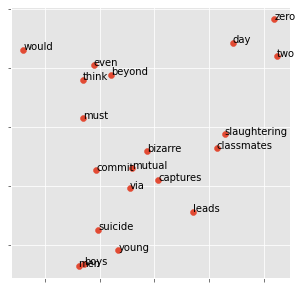

CPU times: user 46.3 s, sys: 235 ms, total: 46.5 s
Wall time: 12 s


In [40]:
%%time
vocabs = list(model.wv.vocab.keys())[:1000]
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model[vocabs])
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:20, 0], vectors_tsne[:20, 1])
for i, word in enumerate(list(vocabs)[:20]):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

In [41]:
# "good"に近い意味の単語を３つ探す
print(model.wv.most_similar(positive="good", topn=3))

# "bad"に近い意味の単語を３つ探す
print(model.wv.most_similar(positive="bad", topn=3))

# "new"に近い意味の単語を３つ探す
print(model.wv.most_similar(positive="new", topn=3))

[('decent', 0.7564993500709534), ('great', 0.686468243598938), ('bad', 0.685073971748352)]
[('horrible', 0.7768165469169617), ('terrible', 0.7701988816261292), ('awful', 0.7656795978546143)]
[('susannah', 0.7644160389900208), ('susanah', 0.7078723907470703), ('sussanah', 0.6272707581520081)]


## 学習済みベクトル
巨大なコーパスで学習して得たベクトルも公開されているため、自分で学習をせずに利用することもできます。オリジナルのWord2Vecの他に同じ作者の発展系である FastText やスタンフォード大の GloVe があり、それぞれ公開されています。



## 【問題8】（アドバンス課題）Word2Vecを用いた映画レビューの分類
問題6で学習して得たベクトルや公開されている学習済みベクトルを用いてIMDB映画レビューデータセットの感情分類の学習・推定を行なってください。

### ●convert_corpus2vector関数

In [42]:
# コーパス⇒ベクトル表現に変換する関数
def convert_corpus2vector(corpus_prepro, wv, vector_size):
    n_sample = len(corpus_prepro)
    vector = np.zeros((n_sample, vector_size))

    # 各コーパスのサンプルごとにWord2Vecベクトルへ変換
    for i, corpus in enumerate(corpus_prepro):
        vector_temp = np.zeros(vector_size)
        for token in corpus:
            # 語彙一覧にトークンが存在する場合はWord2Vecベクトルに変換
            try:
                vector_temp += wv[token]
            # 語彙一覧にトークンが存在しない場合はスルー
            except KeyError:
                pass
        vector[i] = vector_temp

    return vector

### ●学習・推定・評価（Word2Vecサイズ:100）

In [43]:
%%time

vector_size = 100  # ベクトルの次元数

# Word2Vec生成用のモデル
model = Word2Vec(window=5, min_count=1, size=vector_size)
model.build_vocab(x_train_prepro) # 準備
print(model.corpus_count)
print(model.iter)

# 学習
model.train(x_train_prepro, total_examples=model.corpus_count, epochs=model.iter)

# コーパスのサンプルごとにWord2Vecベクトルに変換
x_train_vector = convert_corpus2vector(corpus_prepro=x_train_prepro, wv=model.wv, vector_size=vector_size)
x_test_vector = convert_corpus2vector(corpus_prepro=x_test_prepro, wv=model.wv, vector_size=vector_size)

# trainとvalに分割
X_train2, X_val2, y_train2, y_val2 = train_test_split(x_train_vector, y_train, train_size=0.8, random_state=0)
X_test2 = x_test_vector
y_test2 = y_test

model_wv1 = model

25000
5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  # This is added back by InteractiveShellApp.init_path()


CPU times: user 1min 14s, sys: 497 ms, total: 1min 14s
Wall time: 46 s


X.shape:
(20000, 100)
y.shape:
(20000,)
Xv.shape:
(5000, 100)
yv.shape:
(5000,)
Xt.shape:
(25000, 100)
yt.shape:
(25000,)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1000)              101000    
_________________________________________________________________
dense_4 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 501       
Total params: 602,001
Trainable params: 602,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
625/625 [==============================] - 2s 2ms/step - loss: 0.9459 - accuracy: 0.7866 - val_loss: 0.4702 - val_accuracy: 0.7730

Epoch 00001: val_loss improved from inf to 0.47024, saving model to model_weight.hdf5
Epoch 2/50
625/625 [=====

,0,1
0,10572,1928
1,2066,10434




スコアボード1:


,TF-IDF,Word2Vec(size:100)
Accuacy,0.859480,0.840240
Precision,0.876624,0.844038
Recall,0.836720,0.834720
F1,0.856207,0.839353


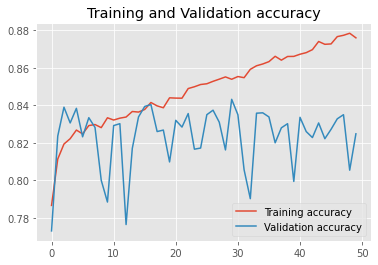

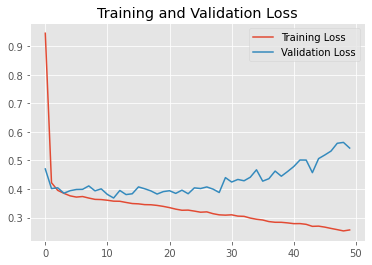

CPU times: user 1min 34s, sys: 13 s, total: 1min 47s
Wall time: 1min 10s


In [44]:
%%time
X = X_train2
y = y_train2
Xv = X_val2
yv = y_val2
Xt = X_test2
yt = y_test2

print("X.shape:")
print(X.shape)
print("y.shape:")
print(y.shape)
print("Xv.shape:")
print(Xv.shape)
print("yv.shape:")
print(yv.shape)
print("Xt.shape:")
print(Xt.shape)
print("yt.shape:")
print(yt.shape)
print("\n")


# ハイパーパラメータの設定
learning_rate = 0.001
batch_size = 10
num_epochs = 50
n_input = X.shape[1]
n_hidden1 = 1000
n_hidden2 = 500
n_samples = X.shape[0]
n_classes = 1

# モデルのインスタンス化
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_input,)),
    tf.keras.layers.Dense(n_hidden1, activation='relu'),
    tf.keras.layers.Dense(n_hidden2, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(n_classes)
    # tf.keras.layers.Dense(n_classes, activation='sigmoid')
])

# 各クラスに属する確率の推定用にモデルを拡張（ロジットをSigmoid関数 or Softmax関数に通す）
probability_model = tf.keras.Sequential([
          model,
          tf.keras.layers.Activation("sigmoid")
          # tf.keras.layers.Softmax()
])

# 最適化手法
optimizer=tf.keras.optimizers.Adam(learning_rate)    # Adam

# 損失関数
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)  # バイナリ交差エントロピー（2値分類）

# メトリクス
metrics=["accuracy"]

# モデルのコンパイル
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics
              )

# モデルのサマリー
model.summary()

# コールバック
callbacks = [
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),  # 早期終了
    tf.keras.callbacks.ModelCheckpoint('model_weight.hdf5', monitor='val_loss',verbose=1, save_best_only=True)  # 学習したパラメータを保存
]

# 学習
history = model.fit(X, y, validation_data=(Xv, yv), epochs=num_epochs, callbacks=callbacks)

# 推定
y_pred_proba = probability_model.predict(Xt)[:, 0]    # モデルの最終出力がロジットの場合
# y_pred_proba = model.predict(Xt)[:, 0]    # モデルの最終出力がSigmoid or Softmaxの場合

# 確率を0, 1に変換
y_pred = np.where(y_pred_proba >0.5, 1, 0)
print("y_pred_proba:")
print(y_pred_proba)
print("y_pred:")
print(y_pred)
print("y_true:")
# print(np.argmax(yt, axis=1))
print(yt)
print("\n")

# 評価
score = model.evaluate(Xt, yt, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

# 推定器のスコアを計算し、スコアボードに記録
columns = "Word2Vec(size:{})".format(vector_size)
score_board1.calcurate_scores(yt, y_pred, arg_columns=columns)

# 学習曲線
plot_training_curve(history=history, metrics_list=metrics)

model1 = model

### ●学習・推定・評価（Word2Vecサイズ:1000）

In [45]:
%%time

vector_size = 1000  # ベクトルの次元数

# Word2Vec生成用のモデル
model = Word2Vec(window=5, min_count=1, size=vector_size)
model.build_vocab(x_train_prepro) # 準備
print(model.corpus_count)
print(model.iter)

# 学習
model.train(x_train_prepro, total_examples=model.corpus_count, epochs=model.iter)

# コーパスのサンプルごとにWord2Vecベクトルに変換
x_train_vector = convert_corpus2vector(corpus_prepro=x_train_prepro, wv=model.wv, vector_size=vector_size)
x_test_vector = convert_corpus2vector(corpus_prepro=x_test_prepro, wv=model.wv, vector_size=vector_size)

# trainとvalに分割
X_train2, X_val2, y_train2, y_val2 = train_test_split(x_train_vector, y_train, train_size=0.8, random_state=0)
X_test2 = x_test_vector
y_test2 = y_test

model_wv2 = model

25000
5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  # This is added back by InteractiveShellApp.init_path()


CPU times: user 2min 30s, sys: 59.7 ms, total: 2min 31s
Wall time: 1min 16s


X.shape:
(20000, 1000)
y.shape:
(20000,)
Xv.shape:
(5000, 1000)
yv.shape:
(5000,)
Xt.shape:
(25000, 1000)
yt.shape:
(25000,)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_7 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 501       
Total params: 1,502,001
Trainable params: 1,502,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
625/625 [==============================] - 2s 3ms/step - loss: 0.9583 - accuracy: 0.7763 - val_loss: 0.4191 - val_accuracy: 0.7984

Epoch 00001: val_loss improved from inf to 0.41910, saving model to model_weight.hdf5
Epoch 2/50
625/625

,0,1
0,10955,1545
1,2484,10016




スコアボード1:


,TF-IDF,Word2Vec(size:100),Word2Vec(size:1000)
Accuacy,0.859480,0.840240,0.838840
Precision,0.876624,0.844038,0.866361
Recall,0.836720,0.834720,0.801280
F1,0.856207,0.839353,0.832551


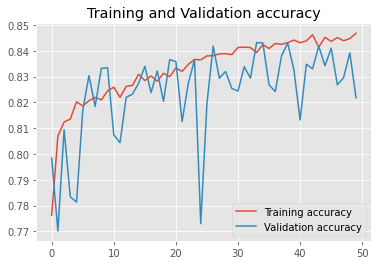

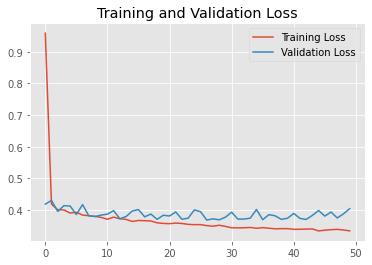

CPU times: user 1min 38s, sys: 13 s, total: 1min 51s
Wall time: 1min 12s


In [46]:
%%time
X = X_train2
y = y_train2
Xv = X_val2
yv = y_val2
Xt = X_test2
yt = y_test2

print("X.shape:")
print(X.shape)
print("y.shape:")
print(y.shape)
print("Xv.shape:")
print(Xv.shape)
print("yv.shape:")
print(yv.shape)
print("Xt.shape:")
print(Xt.shape)
print("yt.shape:")
print(yt.shape)
print("\n")


# ハイパーパラメータの設定
learning_rate = 0.001
batch_size = 10
num_epochs = 50
n_input = X.shape[1]
n_hidden1 = 1000
n_hidden2 = 500
n_samples = X.shape[0]
n_classes = 1

# モデルのインスタンス化
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_input,)),
    tf.keras.layers.Dense(n_hidden1, activation='relu'),
    tf.keras.layers.Dense(n_hidden2, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(n_classes)
    # tf.keras.layers.Dense(n_classes, activation='sigmoid')
])

# 各クラスに属する確率の推定用にモデルを拡張（ロジットをSigmoid関数 or Softmax関数に通す）
probability_model = tf.keras.Sequential([
          model,
          tf.keras.layers.Activation("sigmoid")
          # tf.keras.layers.Softmax()
])

# 最適化手法
optimizer=tf.keras.optimizers.Adam(learning_rate)    # Adam

# 損失関数
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)  # バイナリ交差エントロピー（2値分類）

# メトリクス
metrics=["accuracy"]

# モデルのコンパイル
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics
              )

# モデルのサマリー
model.summary()

# コールバック
callbacks = [
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),  # 早期終了
    tf.keras.callbacks.ModelCheckpoint('model_weight.hdf5', monitor='val_loss',verbose=1, save_best_only=True)  # 学習したパラメータを保存
]

# 学習
history = model.fit(X, y, validation_data=(Xv, yv), epochs=num_epochs, callbacks=callbacks)

# 推定
y_pred_proba = probability_model.predict(Xt)[:, 0]    # モデルの最終出力がロジットの場合
# y_pred_proba = model.predict(Xt)[:, 0]    # モデルの最終出力がSigmoid or Softmaxの場合

# 確率を0, 1に変換
y_pred = np.where(y_pred_proba >0.5, 1, 0)
print("y_pred_proba:")
print(y_pred_proba)
print("y_pred:")
print(y_pred)
print("y_true:")
# print(np.argmax(yt, axis=1))
print(yt)
print("\n")

# 評価
score = model.evaluate(Xt, yt, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

# 推定器のスコアを計算し、スコアボードに記録
columns = "Word2Vec(size:{})".format(vector_size)
score_board1.calcurate_scores(yt, y_pred, arg_columns=columns)

# 学習曲線
plot_training_curve(history=history, metrics_list=metrics)

### ●学習・推定・評価（学習済みWord2Vecモデル（glove-twitter-200）を使用）

In [47]:
## 試しに学習済みモデルをダウンロードして使用してみる ##

import gensim.downloader
# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))

# Download pre-trained embedding model
model_name = 'glove-twitter-200'
glove_vectors = gensim.downloader.load(model_name)

# Use the downloaded vectors as usual:
glove_vectors.most_similar('twitter')

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']
[==================================================] 100.0% 758.5/758.5MB downloaded


[('facebook', 0.8568581342697144),
 ('fb', 0.7988277673721313),
 ('instagram', 0.7892554402351379),
 ('twiter', 0.750034749507904),
 ('tumblr', 0.7478636503219604),
 ('tweets', 0.7417171597480774),
 ('tweet', 0.7320737838745117),
 ('tl', 0.7200853824615479),
 ('timeline', 0.7121856212615967),
 ('internet', 0.6938603520393372)]

In [48]:
%%time

vector_size = 200  # 学習済みモデルのベクトルサイズは、モデル名のsuffixとして付与されている数字がそれに相当するっぽい

# コーパスのサンプルごとにWord2Vecベクトルに変換
x_train_vector = convert_corpus2vector(corpus_prepro=x_train_prepro, wv=glove_vectors, vector_size=vector_size)
x_test_vector = convert_corpus2vector(corpus_prepro=x_test_prepro, wv=glove_vectors, vector_size=vector_size)

# trainとvalに分割
X_train2, X_val2, y_train2, y_val2 = train_test_split(x_train_vector, y_train, train_size=0.8, random_state=0)
X_test2 = x_test_vector
y_test2 = y_test

# model_wv2 = model

CPU times: user 18.9 s, sys: 312 ms, total: 19.2 s
Wall time: 18.8 s


X.shape:
(20000, 200)
y.shape:
(20000,)
Xv.shape:
(5000, 200)
yv.shape:
(5000,)
Xt.shape:
(25000, 200)
yt.shape:
(25000,)


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1000)              201000    
_________________________________________________________________
dense_10 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 501       
Total params: 702,001
Trainable params: 702,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
625/625 [==============================] - 2s 2ms/step - loss: 1.0250 - accuracy: 0.7583 - val_loss: 0.4278 - val_accuracy: 0.7932

Epoch 00001: val_loss improved from inf to 0.42781, saving model to model_weight.hdf5
Epoch 2/50
625/625 [=====

,0,1
0,10346,2154
1,2875,9625




スコアボード1:


,TF-IDF,Word2Vec(size:100),Word2Vec(size:1000),Word2Vec(pre_trained_model: glove-twitter-200)
Accuacy,0.859480,0.840240,0.838840,0.798840
Precision,0.876624,0.844038,0.866361,0.817132
Recall,0.836720,0.834720,0.801280,0.770000
F1,0.856207,0.839353,0.832551,0.792866


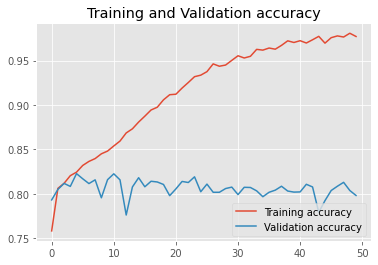

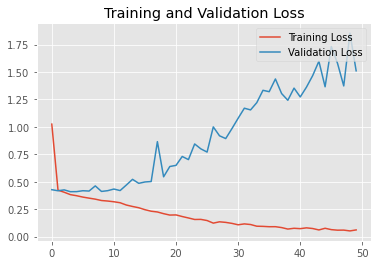

CPU times: user 1min 32s, sys: 12.9 s, total: 1min 45s
Wall time: 1min 8s


In [49]:
%%time
X = X_train2
y = y_train2
Xv = X_val2
yv = y_val2
Xt = X_test2
yt = y_test2

print("X.shape:")
print(X.shape)
print("y.shape:")
print(y.shape)
print("Xv.shape:")
print(Xv.shape)
print("yv.shape:")
print(yv.shape)
print("Xt.shape:")
print(Xt.shape)
print("yt.shape:")
print(yt.shape)
print("\n")


# ハイパーパラメータの設定
learning_rate = 0.001
batch_size = 10
num_epochs = 50
n_input = X.shape[1]
n_hidden1 = 1000
n_hidden2 = 500
n_samples = X.shape[0]
n_classes = 1

# モデルのインスタンス化
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_input,)),
    tf.keras.layers.Dense(n_hidden1, activation='relu'),
    tf.keras.layers.Dense(n_hidden2, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(n_classes)
    # tf.keras.layers.Dense(n_classes, activation='sigmoid')
])

# 各クラスに属する確率の推定用にモデルを拡張（ロジットをSigmoid関数 or Softmax関数に通す）
probability_model = tf.keras.Sequential([
          model,
          tf.keras.layers.Activation("sigmoid")
          # tf.keras.layers.Softmax()
])

# 最適化手法
optimizer=tf.keras.optimizers.Adam(learning_rate)    # Adam

# 損失関数
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)  # バイナリ交差エントロピー（2値分類）

# メトリクス
metrics=["accuracy"]

# モデルのコンパイル
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics
              )

# モデルのサマリー
model.summary()

# コールバック
callbacks = [
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),  # 早期終了
    tf.keras.callbacks.ModelCheckpoint('model_weight.hdf5', monitor='val_loss',verbose=1, save_best_only=True)  # 学習したパラメータを保存
]

# 学習
history = model.fit(X, y, validation_data=(Xv, yv), epochs=num_epochs, callbacks=callbacks)

# 推定
y_pred_proba = probability_model.predict(Xt)[:, 0]    # モデルの最終出力がロジットの場合
# y_pred_proba = model.predict(Xt)[:, 0]    # モデルの最終出力がSigmoid or Softmaxの場合

# 確率を0, 1に変換
y_pred = np.where(y_pred_proba >0.5, 1, 0)
print("y_pred_proba:")
print(y_pred_proba)
print("y_pred:")
print(y_pred)
print("y_true:")
# print(np.argmax(yt, axis=1))
print(yt)
print("\n")

# 評価
score = model.evaluate(Xt, yt, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

# 推定器のスコアを計算し、スコアボードに記録
columns = "Word2Vec(pre_trained_model: {})".format(model_name)
score_board1.calcurate_scores(yt, y_pred, arg_columns=columns)

# 学習曲線
plot_training_curve(history=history, metrics_list=metrics)

### ●学習・推定・評価（学習済みWord2Vecモデル（glove-wiki-gigaword-300）を使用）

In [50]:
%%time
# Download pre-trained embedding model
model_name = 'glove-wiki-gigaword-300'
glove_vectors = gensim.downloader.load(model_name)

vector_size = 300  # 学習済みモデルのベクトルサイズは、モデル名のsuffixとして付与されている数字がそれに相当するっぽい

# コーパスのサンプルごとにWord2Vecベクトルに変換
x_train_vector = convert_corpus2vector(corpus_prepro=x_train_prepro, wv=glove_vectors, vector_size=vector_size)
x_test_vector = convert_corpus2vector(corpus_prepro=x_test_prepro, wv=glove_vectors, vector_size=vector_size)

# trainとvalに分割
X_train2, X_val2, y_train2, y_val2 = train_test_split(x_train_vector, y_train, train_size=0.8, random_state=0)
X_test2 = x_test_vector
y_test2 = y_test

# model_wv2 = model

[==================================================] 100.0% 376.1/376.1MB downloaded
CPU times: user 3min 22s, sys: 17.1 s, total: 3min 39s
Wall time: 3min 28s


X.shape:
(20000, 300)
y.shape:
(20000,)
Xv.shape:
(5000, 300)
yv.shape:
(5000,)
Xt.shape:
(25000, 300)
yt.shape:
(25000,)


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1000)              301000    
_________________________________________________________________
dense_13 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 501       
Total params: 802,001
Trainable params: 802,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
625/625 [==============================] - 2s 2ms/step - loss: 0.6592 - accuracy: 0.7760 - val_loss: 0.4675 - val_accuracy: 0.8116

Epoch 00001: val_loss improved from inf to 0.46751, saving model to model_weight.hdf5
Epoch 2/50
625/625 [=====

,0,1
0,10423,2077
1,2562,9938




スコアボード1:


,TF-IDF,Word2Vec(size:100),Word2Vec(size:1000),Word2Vec(pre_trained_model: glove-twitter-200),Word2Vec(pre_trained_model: glove-wiki-gigaword-300)
Accuacy,0.859480,0.840240,0.838840,0.798840,0.814440
Precision,0.876624,0.844038,0.866361,0.817132,0.827133
Recall,0.836720,0.834720,0.801280,0.770000,0.795040
F1,0.856207,0.839353,0.832551,0.792866,0.810769


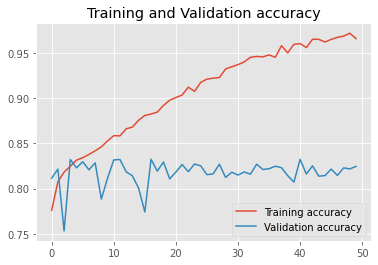

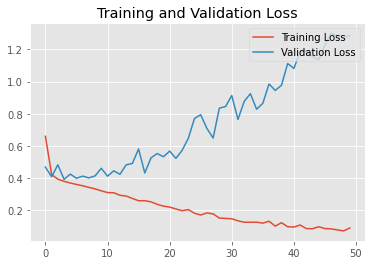

CPU times: user 1min 33s, sys: 12.7 s, total: 1min 45s
Wall time: 1min 8s


In [51]:
%%time
X = X_train2
y = y_train2
Xv = X_val2
yv = y_val2
Xt = X_test2
yt = y_test2

print("X.shape:")
print(X.shape)
print("y.shape:")
print(y.shape)
print("Xv.shape:")
print(Xv.shape)
print("yv.shape:")
print(yv.shape)
print("Xt.shape:")
print(Xt.shape)
print("yt.shape:")
print(yt.shape)
print("\n")


# ハイパーパラメータの設定
learning_rate = 0.001
batch_size = 10
num_epochs = 50
n_input = X.shape[1]
n_hidden1 = 1000
n_hidden2 = 500
n_samples = X.shape[0]
n_classes = 1

# モデルのインスタンス化
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_input,)),
    tf.keras.layers.Dense(n_hidden1, activation='relu'),
    tf.keras.layers.Dense(n_hidden2, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(n_classes)
    # tf.keras.layers.Dense(n_classes, activation='sigmoid')
])

# 各クラスに属する確率の推定用にモデルを拡張（ロジットをSigmoid関数 or Softmax関数に通す）
probability_model = tf.keras.Sequential([
          model,
          tf.keras.layers.Activation("sigmoid")
          # tf.keras.layers.Softmax()
])

# 最適化手法
optimizer=tf.keras.optimizers.Adam(learning_rate)    # Adam

# 損失関数
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)  # バイナリ交差エントロピー（2値分類）

# メトリクス
metrics=["accuracy"]

# モデルのコンパイル
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics
              )

# モデルのサマリー
model.summary()

# コールバック
callbacks = [
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),  # 早期終了
    tf.keras.callbacks.ModelCheckpoint('model_weight.hdf5', monitor='val_loss',verbose=1, save_best_only=True)  # 学習したパラメータを保存
]

# 学習
history = model.fit(X, y, validation_data=(Xv, yv), epochs=num_epochs, callbacks=callbacks)

# 推定
y_pred_proba = probability_model.predict(Xt)[:, 0]    # モデルの最終出力がロジットの場合
# y_pred_proba = model.predict(Xt)[:, 0]    # モデルの最終出力がSigmoid or Softmaxの場合

# 確率を0, 1に変換
y_pred = np.where(y_pred_proba >0.5, 1, 0)
print("y_pred_proba:")
print(y_pred_proba)
print("y_pred:")
print(y_pred)
print("y_true:")
# print(np.argmax(yt, axis=1))
print(yt)
print("\n")

# 評価
score = model.evaluate(Xt, yt, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

# 推定器のスコアを計算し、スコアボードに記録
columns = "Word2Vec(pre_trained_model: {})".format(model_name)
score_board1.calcurate_scores(yt, y_pred, arg_columns=columns)

# 学習曲線
plot_training_curve(history=history, metrics_list=metrics)

### ●学習・推定・評価（学習済みWord2Vecモデル（word2vec-google-news-300）を使用）

In [52]:
%%time
# Download pre-trained embedding model
model_name = 'word2vec-google-news-300'
glove_vectors = gensim.downloader.load(model_name)

vector_size = 300  # 学習済みモデルのベクトルサイズは、モデル名のsuffixとして付与されている数字がそれに相当するっぽい

# コーパスのサンプルごとにWord2Vecベクトルに変換
x_train_vector = convert_corpus2vector(corpus_prepro=x_train_prepro, wv=glove_vectors, vector_size=vector_size)
x_test_vector = convert_corpus2vector(corpus_prepro=x_test_prepro, wv=glove_vectors, vector_size=vector_size)

# trainとvalに分割
X_train2, X_val2, y_train2, y_val2 = train_test_split(x_train_vector, y_train, train_size=0.8, random_state=0)
X_test2 = x_test_vector
y_test2 = y_test

# model_wv2 = model

[==================================================] 100.0% 1662.8/1662.8MB downloaded
CPU times: user 7min 46s, sys: 1min 14s, total: 9min
Wall time: 8min 9s


X.shape:
(20000, 300)
y.shape:
(20000,)
Xv.shape:
(5000, 300)
yv.shape:
(5000,)
Xt.shape:
(25000, 300)
yt.shape:
(25000,)


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 1000)              301000    
_________________________________________________________________
dense_16 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 501       
Total params: 802,001
Trainable params: 802,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
625/625 [==============================] - 2s 2ms/step - loss: 0.5380 - accuracy: 0.7889 - val_loss: 0.3724 - val_accuracy: 0.8250

Epoch 00001: val_loss improved from inf to 0.37238, saving model to model_weight.hdf5
Epoch 2/50
625/625 [====

,0,1
0,10522,1978
1,2012,10488




スコアボード1:


,TF-IDF,Word2Vec(size:100),Word2Vec(size:1000),Word2Vec(pre_trained_model: glove-twitter-200),Word2Vec(pre_trained_model: glove-wiki-gigaword-300),Word2Vec(pre_trained_model: word2vec-google-news-300)
Accuacy,0.859480,0.840240,0.838840,0.798840,0.814440,0.840400
Precision,0.876624,0.844038,0.866361,0.817132,0.827133,0.841328
Recall,0.836720,0.834720,0.801280,0.770000,0.795040,0.839040
F1,0.856207,0.839353,0.832551,0.792866,0.810769,0.840183


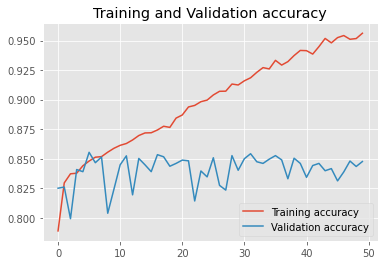

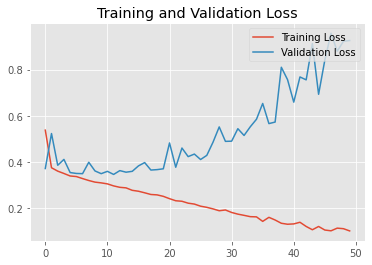

CPU times: user 1min 31s, sys: 12.6 s, total: 1min 44s
Wall time: 1min 7s


In [53]:
%%time
X = X_train2
y = y_train2
Xv = X_val2
yv = y_val2
Xt = X_test2
yt = y_test2

print("X.shape:")
print(X.shape)
print("y.shape:")
print(y.shape)
print("Xv.shape:")
print(Xv.shape)
print("yv.shape:")
print(yv.shape)
print("Xt.shape:")
print(Xt.shape)
print("yt.shape:")
print(yt.shape)
print("\n")


# ハイパーパラメータの設定
learning_rate = 0.001
batch_size = 10
num_epochs = 50
n_input = X.shape[1]
n_hidden1 = 1000
n_hidden2 = 500
n_samples = X.shape[0]
n_classes = 1

# モデルのインスタンス化
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_input,)),
    tf.keras.layers.Dense(n_hidden1, activation='relu'),
    tf.keras.layers.Dense(n_hidden2, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(n_classes)
    # tf.keras.layers.Dense(n_classes, activation='sigmoid')
])

# 各クラスに属する確率の推定用にモデルを拡張（ロジットをSigmoid関数 or Softmax関数に通す）
probability_model = tf.keras.Sequential([
          model,
          tf.keras.layers.Activation("sigmoid")
          # tf.keras.layers.Softmax()
])

# 最適化手法
optimizer=tf.keras.optimizers.Adam(learning_rate)    # Adam

# 損失関数
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)  # バイナリ交差エントロピー（2値分類）

# メトリクス
metrics=["accuracy"]

# モデルのコンパイル
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics
              )

# モデルのサマリー
model.summary()

# コールバック
callbacks = [
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),  # 早期終了
    tf.keras.callbacks.ModelCheckpoint('model_weight.hdf5', monitor='val_loss',verbose=1, save_best_only=True)  # 学習したパラメータを保存
]

# 学習
history = model.fit(X, y, validation_data=(Xv, yv), epochs=num_epochs, callbacks=callbacks)

# 推定
y_pred_proba = probability_model.predict(Xt)[:, 0]    # モデルの最終出力がロジットの場合
# y_pred_proba = model.predict(Xt)[:, 0]    # モデルの最終出力がSigmoid or Softmaxの場合

# 確率を0, 1に変換
y_pred = np.where(y_pred_proba >0.5, 1, 0)
print("y_pred_proba:")
print(y_pred_proba)
print("y_pred:")
print(y_pred)
print("y_true:")
# print(np.argmax(yt, axis=1))
print(yt)
print("\n")

# 評価
score = model.evaluate(Xt, yt, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

# 推定器のスコアを計算し、スコアボードに記録
columns = "Word2Vec(pre_trained_model: {})".format(model_name)
score_board1.calcurate_scores(yt, y_pred, arg_columns=columns)

# 学習曲線
plot_training_curve(history=history, metrics_list=metrics)

### 【問題8 解答】
IMDB映画レビューのデータセットのコーパスを対象にしてベクトルサイズが100と1000の二通りのモデルを作成し、それを用いて各コーパスのサンプルをベクトルへ変換してDNNモデルで学習・推定を実施した。

その結果、いずれもある程度高い推定精度が得られたが、TF-IDFを対象に学習・推定を行った場合に比べると推定精度は僅かに低くなった。

また、3種類の学習済みWord2Vecモデルを用いて同様に映画レビューデータセットをベクトルへ変換してDNNモデルで学習・推定を行ったところ、「word2vec-google-news-300」のWord2VecモデルについてはIMDB映画レビューデータセットから作成したWord2Vecと同等の精度が得られたが、それ以外の学習済みモデルについては全体的に推定精度が下がってしまった。


DNNの中間層のノード数を調整することで改善する可能性もあるが、今回の結果を見た限りでは、ユーザーの評価をコーパスから数値化する際にはそのドメインに関する文章のみに基づいてWord2Vecのベクトル化を行った方が推定精度が高くなる傾向が見られた。
